# Embeddings comparison

---



## Setup

In [1]:
import sys
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
sys.path.append('vggish')

In [2]:
from collections import namedtuple
import glob

import numpy as np
import matplotlib.pyplot as plt
from openl3 import preprocess_audio
from openl3.core import load_audio_embedding_model
import tensorflow.compat.v1 as tf1
import tensorflow as tf2
tf1.get_logger().setLevel('ERROR')
tf2.get_logger().setLevel('ERROR')

%run configurations-gen.ipynb
from audio import load_file
from vggish import vggish_params, vggish_input, vggish_slim, vggish_postprocess

In [3]:
VGGISH_MODEL = vggish_folder + '/vggish_model.ckpt'
PCA_PARAMS = vggish_folder + '/vggish_pca_params.npz'

figure_folder = data_folder + '/figures'
os.makedirs(figure_folder, exist_ok=True)

In [4]:
Embedding = namedtuple('Embedding', ['name', 'get_spectrogram', 'get_embedding'])

In [5]:
def get_vggish_spectrogram(sample_wave, sample_sr):
    return vggish_input.waveform_to_examples(sample_wave, sample_sr)

def get_vggish_embedding(spect):
    with tf1.Graph().as_default():
        sess = tf1.Session()
        vggish_slim.define_vggish_slim(training=False)
        vggish_slim.load_vggish_slim_checkpoint(sess, VGGISH_MODEL)
        postprocessor = vggish_postprocess.Postprocessor(PCA_PARAMS)
        
        features_tensor = sess.graph.get_tensor_by_name(vggish_params.INPUT_TENSOR_NAME)
        embedding_tensor = sess.graph.get_tensor_by_name(vggish_params.OUTPUT_TENSOR_NAME)
        
        [embedding_batch] = sess.run(
            [embedding_tensor],
            feed_dict={features_tensor: spect}
        )
        
        postprocessed_batch = postprocessor.postprocess(embedding_batch)
        
        return postprocessed_batch

In [6]:
def get_openl3_spectrogram(sample_wave, sample_sr, input_repr='mel256'):
    sample_wave = sample_wave / 32768.0
    return preprocess_audio(sample_wave, sample_sr, input_repr=input_repr)

def get_openl3_embedding(spect, input_repr='mel256'):
    openl3_model = load_audio_embedding_model(input_repr=input_repr, content_type='env', embedding_size=512, frontend='librosa')
    embedding_batch = openl3_model.predict(spect, verbose=0)
    return embedding_batch

In [7]:
embeddings = [
    Embedding('VGGish', get_vggish_spectrogram, get_vggish_embedding),
    Embedding('OpenL3', get_openl3_spectrogram, get_openl3_embedding),
]

In [8]:
# sample_file = glob.glob(dataset_folder + '/*/*/*.wav')[0]
sample_file = '../../data/data_augmentation/dataset/2_mopeds/B-AS-roos-001.200120.133315.48.wav'
print('Using file', sample_file)
sample_SR_openl3, sample_wave_openl3 = load_file(sample_file, 48000, False)
sample_SR_vggish, sample_wave_vggish = load_file(sample_file, 16000, False)

Using file ../../data/data_augmentation/dataset/2_mopeds/B-AS-roos-001.200120.133315.48.wav


## VGGish spectrogram & embedding

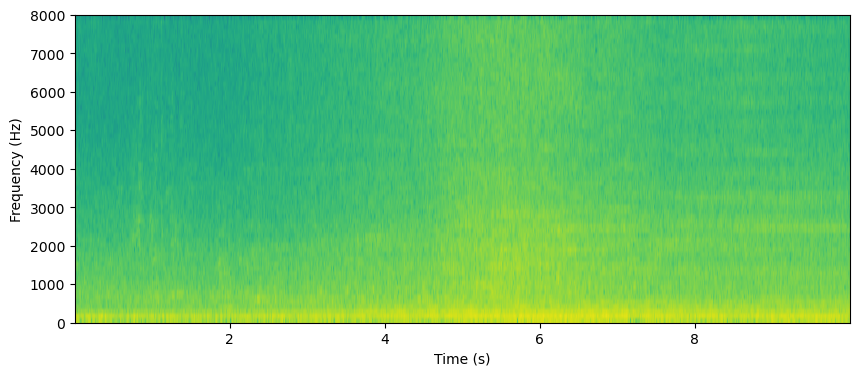

In [9]:
plt.rcParams['figure.figsize'] = [10, 4]
plt.specgram(x=sample_wave_vggish, Fs=sample_SR_vggish, NFFT=128, noverlap=64)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.savefig(figure_folder + '/fig_vggish_spectrogram.pdf', bbox_inches='tight')
plt.show()

(10, 96, 64)

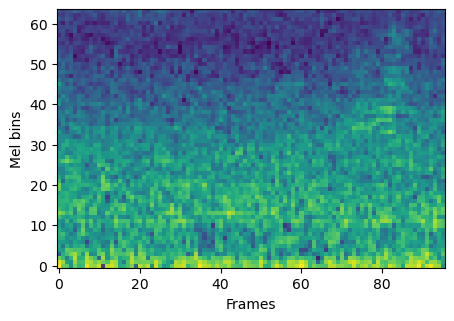

C:\Users\Max\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
C:\Users\Max\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:332: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  warnings.warn('`tf.layers.flatten` is deprecated and '


(10, 128)

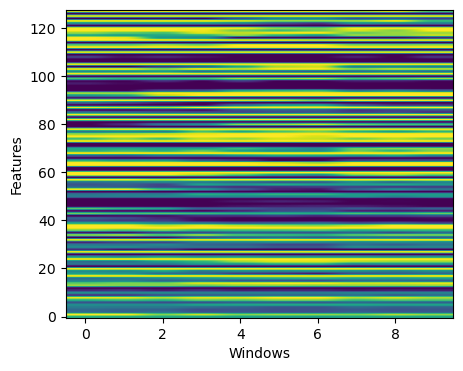

In [10]:
plt.rcParams['figure.figsize'] = [5, 4]
spect = np.squeeze(embeddings[0].get_spectrogram(sample_wave_vggish, sample_SR_vggish))
display(np.shape(spect))
plt.imshow(spect[0].transpose(), origin='lower')
plt.xlabel('Frames')
plt.ylabel('Mel bins')
plt.savefig(figure_folder + '/fig_vggish_spectrogram_window.pdf', bbox_inches='tight')
plt.show()
embedded = embeddings[0].get_embedding(spect)
display(np.shape(embedded))
plt.xlabel('Windows')
plt.ylabel('Features')
plt.imshow(embedded.transpose(), origin='lower', aspect='auto')
plt.savefig(figure_folder + '/fig_vggish_embedding.pdf', bbox_inches='tight')
plt.show()

## OpenL3 spectrogram & embedding

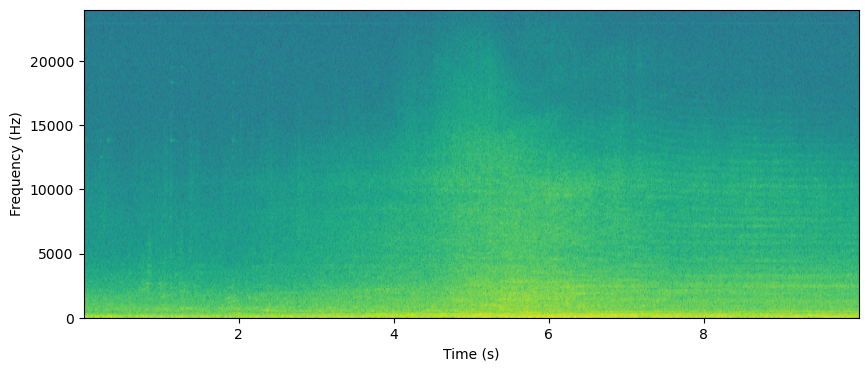

In [11]:
plt.rcParams['figure.figsize'] = [10, 4]
plt.specgram(x=sample_wave_openl3, Fs=sample_SR_openl3, NFFT=512, noverlap=256)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.savefig(figure_folder + '/fig_openl3_spectrogram.pdf', bbox_inches='tight')
plt.show()

(96, 256, 199)

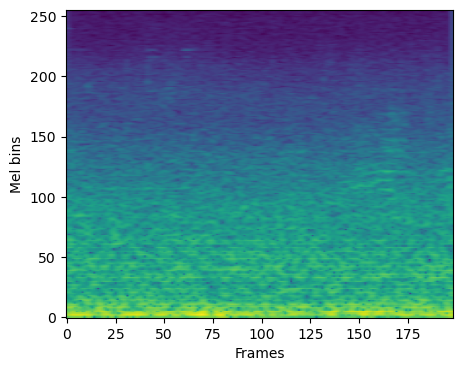

(96, 512)

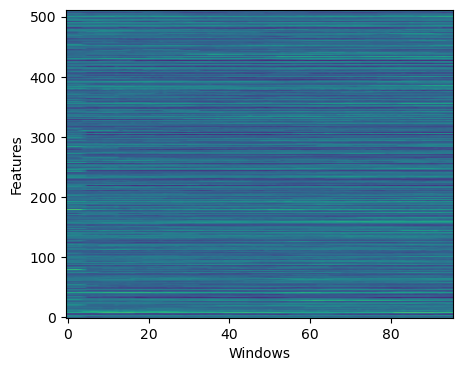

In [12]:
plt.rcParams['figure.figsize'] = [5, 4]
spect = np.squeeze(embeddings[1].get_spectrogram(sample_wave_openl3, sample_SR_openl3))
display(np.shape(spect))
plt.imshow(spect[5], origin='lower', aspect='auto')
plt.xlabel('Frames')
plt.ylabel('Mel bins')
plt.savefig(figure_folder + '/fig_openl3_spectrogram_window.pdf', bbox_inches='tight')
plt.show()
embedded = embeddings[1].get_embedding(spect)
display(np.shape(embedded))
plt.imshow(embedded.transpose(), origin='lower', aspect='auto')
plt.xlabel('Windows')
plt.ylabel('Features')
plt.savefig(figure_folder + '/fig_openl3_embedding.pdf', bbox_inches='tight')
plt.show()

## Openl3 embedding options

(96, 257, 197)

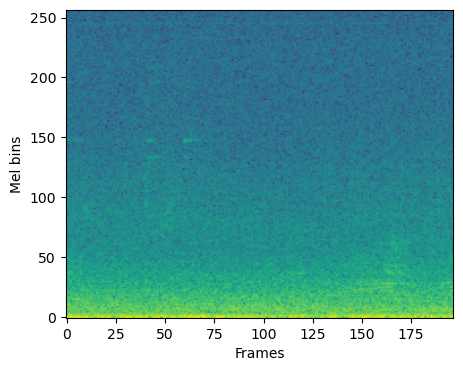

(96, 512)

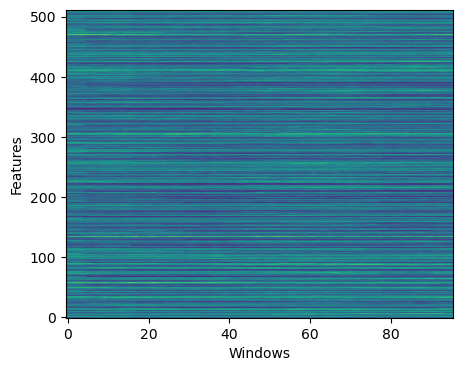

(96, 128, 199)

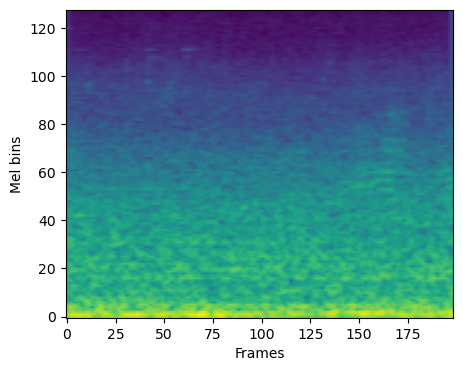

(96, 512)

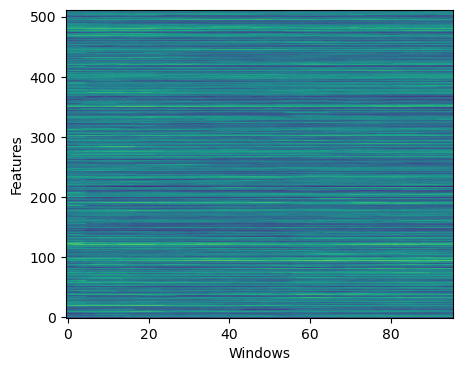

(96, 256, 199)

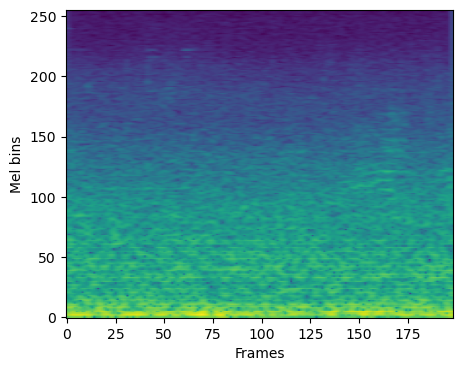

(96, 512)

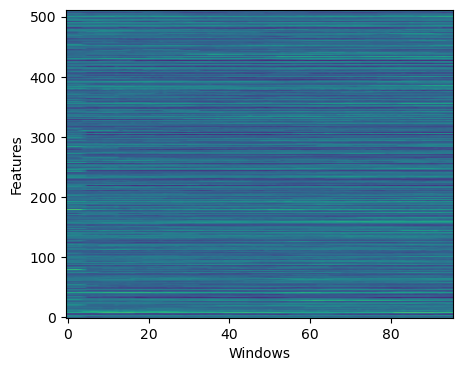

In [14]:
plt.rcParams['figure.figsize'] = [5, 4]

for input_repr in ['linear', 'mel128', 'mel256']:
    spect = np.squeeze(embeddings[1].get_spectrogram(sample_wave_openl3, sample_SR_openl3, input_repr))
    display(np.shape(spect))
    plt.imshow(spect[5], origin='lower', aspect='auto')
    plt.xlabel('Frames')
    plt.ylabel('Mel bins')
    plt.savefig(figure_folder + f'/fig_openl3_window_{input_repr}.pdf', bbox_inches='tight')
    plt.show()
    embedded = embeddings[1].get_embedding(spect, input_repr)
    display(np.shape(embedded))
    plt.imshow(embedded.transpose(), origin='lower', aspect='auto')
    plt.xlabel('Windows')
    plt.ylabel('Features')
    # plt.savefig(figure_folder + '/fig_openl3_embedding.pdf', bbox_inches='tight')
    plt.show()